In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import mysql.connector
import networkx as nx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,MultiPolygon,LineString,MultiLineString,LinearRing,Point
from shapely import symmetric_difference
from shapely.ops import nearest_points
from shapely.wkt import loads
import scipy
import time
import numpy as np
import random
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import osmnx as ox
import glob
from itertools import combinations,product
from copy import deepcopy
import os
from lib_contour_lines import *
import mysql.connector


In [2]:

user='spirz'
password='this_is_my_PASSWORD_m8'
host='localhost'
database='dem_from_contours_lines'
contours_lines_table_name='contours_lines'
osm_nodes_table_name="osm_nodes"
osm_edges_table_name="osm_edges"
intersections_table_name="intersections"


2

2

In [3]:
DBM=DataBaseManager(user=user,password=password,host=host,database=database,
            contours_lines_table_name=contours_lines_table_name,
            osm_nodes_table_name=osm_nodes_table_name,
            osm_edges_table_name=osm_edges_table_name,
            intersections_table_name=intersections_table_name)
2

2

In [4]:
t1=time.time()
place_name='Corse, France'
G_osm=ox.graph_from_place(place_name,network_type='drive')

t2=time.time()
print(t2-t1)
len(G_osm.nodes()),len(G_osm.edges())

55.90025520324707


(17435, 37758)

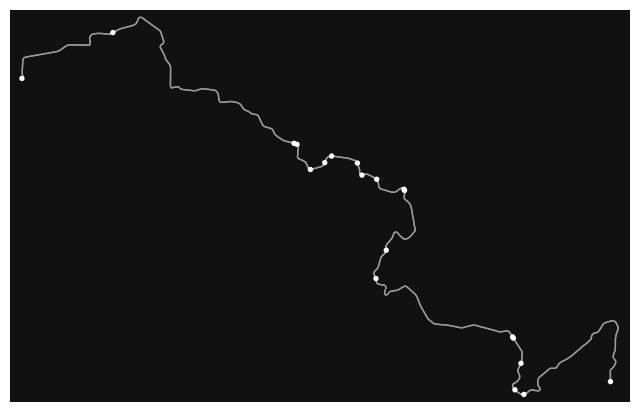

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
lat_1,lon_1=42.583253, 8.831825
lat_2,lon_2=42.543587, 8.931477
node_1,node_2=ox.nearest_nodes(G_osm,[lon_1,lon_2],[lat_1,lat_2])
path=nx.shortest_path(G_osm,node_1,node_2,weight='length')
ox.plot_graph(nx.subgraph(G_osm,path))

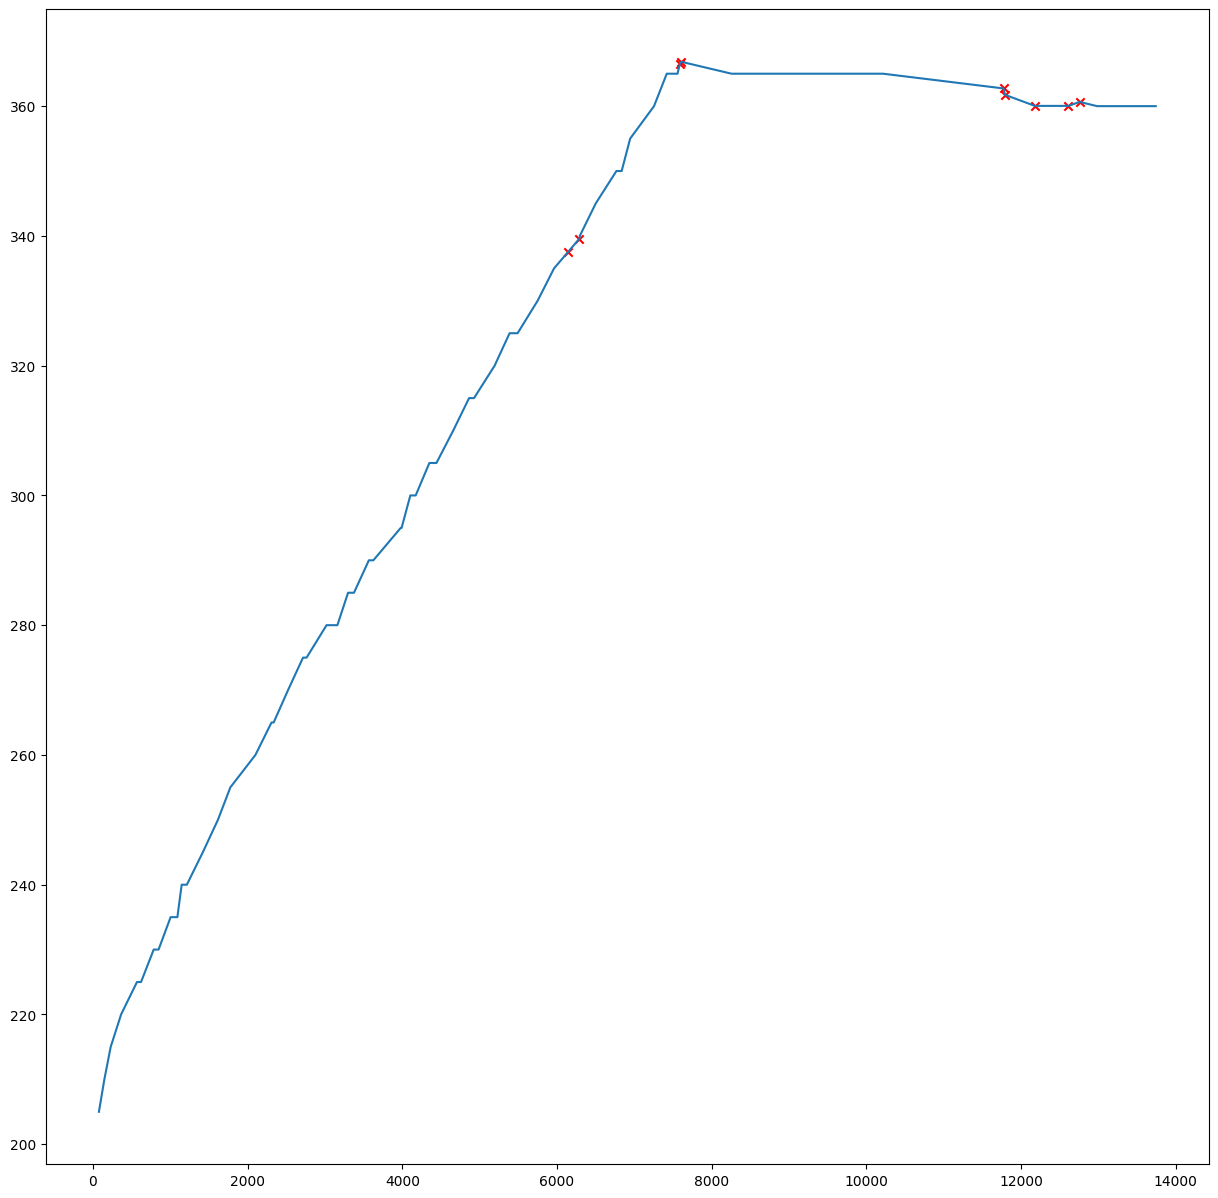

In [6]:
plt.rcParams['figure.figsize']=(15,15)
edge_coordinates,elevations,nodes_coordinates,nodes_elevations=DBM.get_altimetric_profile(G_osm,path)
plt.plot(edge_coordinates,elevations)
plt.scatter(nodes_coordinates,nodes_elevations,marker='x',c='r')

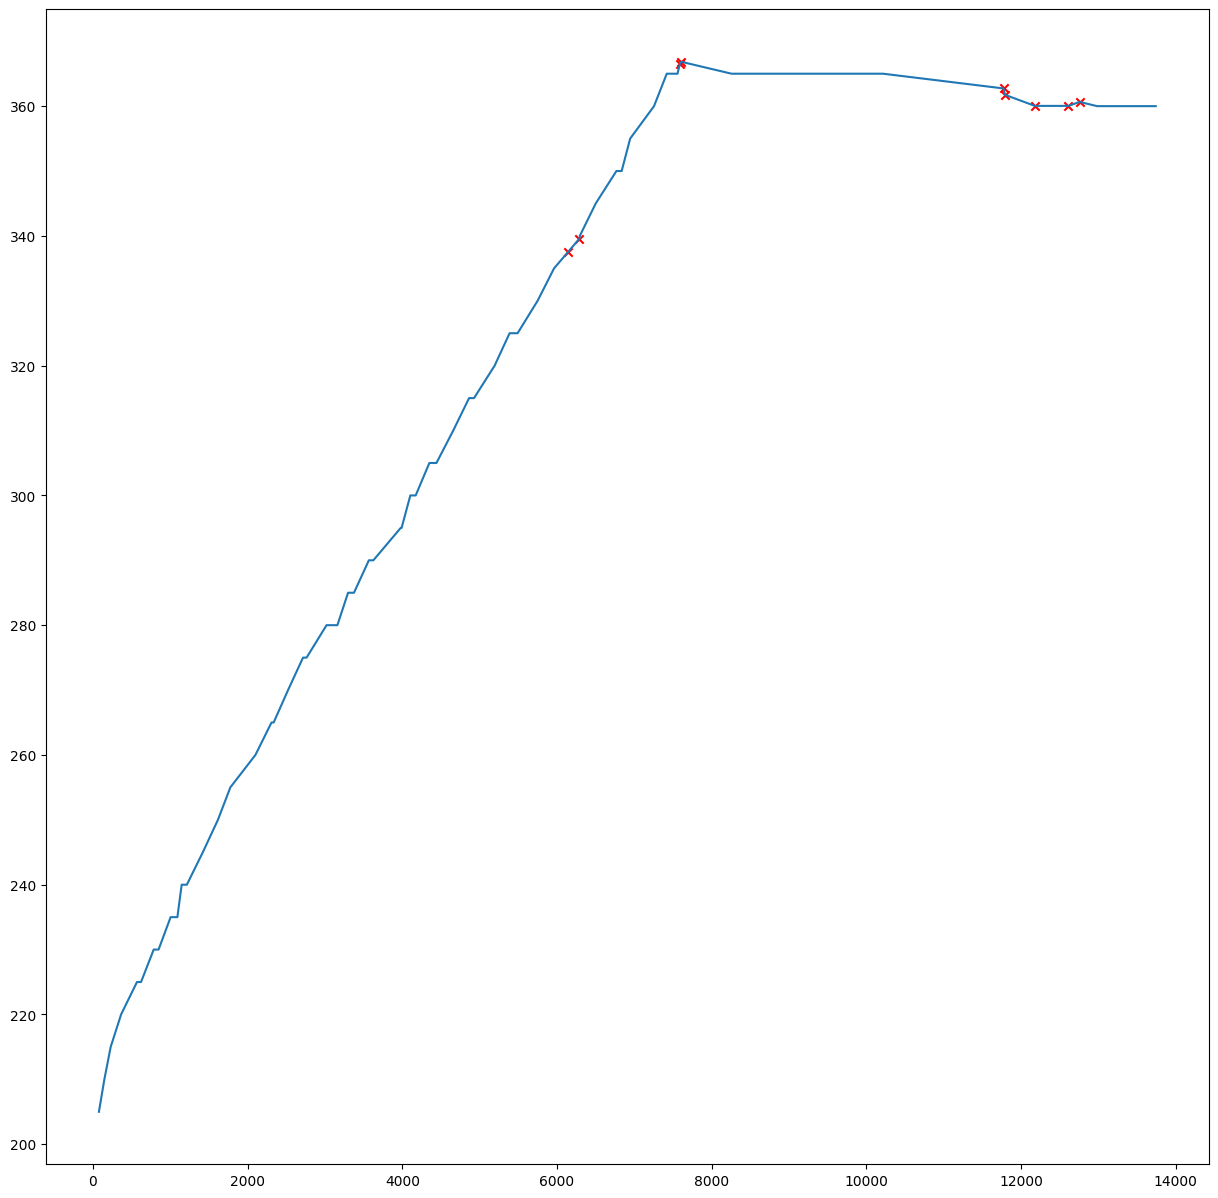

In [10]:
plt.rcParams['figure.figsize']=(15,15)
plt.plot(edge_coordinates,elevations)
plt.scatter(nodes_coordinates,nodes_elevations,marker='x',c='r')